In [6]:
# scraping
import requests
import json
import pandas as pd
import numpy as np

# embedding
from transformers import AutoTokenizer, AutoModel # Longformer
from transformers import BertModel, BertTokenizerFast # BERT

# classification
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb # XGBoost

# evaluation
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/quality-groups-of-wikipedia-articles/Stub_raw.csv
/kaggle/input/quality-groups-of-wikipedia-articles/B_raw.csv
/kaggle/input/quality-groups-of-wikipedia-articles/FA_raw.csv
/kaggle/input/quality-groups-of-wikipedia-articles/GA_raw.csv
/kaggle/input/quality-groups-of-wikipedia-articles/A_raw.csv
/kaggle/input/quality-groups-of-wikipedia-articles/Start_raw.csv


In [7]:
FA = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/FA_raw.csv')
A = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/A_raw.csv')
GA = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/GA_raw.csv')
B = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/B_raw.csv')
Start = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/Start_raw.csv')
Stub = pd.read_csv('/kaggle/input/quality-groups-of-wikipedia-articles/Stub_raw.csv')

dfs = [Stub, Start, B, GA, A, FA]

In [8]:
longformer_tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
longformer_model = AutoModel.from_pretrained('allenai/longformer-base-4096')

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
longformer_model.to(device)

LongformerModel(
  (embeddings): LongformerEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (position_embeddings): Embedding(4098, 768, padding_idx=1)
  )
  (encoder): LongformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x LongformerLayer(
        (attention): LongformerAttention(
          (self): LongformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (query_global): Linear(in_features=768, out_features=768, bias=True)
            (key_global): Linear(in_features=768, out_features=768, bias=True)
            (value_global): Linear(in_features=768, out_features=768, bias=True)
          )
    

In [16]:
def get_pooler_output(text, tokenizer, model, device, max_length=4096):
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    tokens = {k: v.to(device) for k, v in tokens.items()}  # Move tokens to the GPU
    with torch.no_grad():
        output = model(**tokens)
    return output.pooler_output.cpu()

In [5]:
!neofetch

            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@df55865dd3ac 
----------------- 
OS: Ubuntu 20.04.6 LTS x86_64 
Host: Google Compute Engine 
Kernel: 5.15.133+ 
Uptime: 5 mins 
Packages: 725 (dpkg) 
Shell: bash 5.0.17 
Terminal: jupyter-noteboo 
CPU: Intel Xeon (4) @ 2.000GHz 
GPU: NVIDIA Tesla 

In [22]:
for df in dfs:
    df['Longformer_embedding'] = df['raw'].apply(lambda x: get_pooler_output(x, longformer_tokenizer, longformer_model, device, 4096))

In [27]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.to(device)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [28]:
def get_cls_embedding(text, tokenizer, model, device, max_length=512):
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    tokens = {k: v.to(device) for k, v in tokens.items()}  
    with torch.no_grad():
        outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu() 
    return cls_embedding

In [29]:
for df in dfs:
    df['BERT_embedding'] = df['raw'].apply(lambda x: get_cls_embedding(x, bert_tokenizer, bert_model, device, 512))

In [32]:
Stub.to_csv(f"/kaggle/working/Stub_embeddings.csv", index=False)
Start.to_csv(f"/kaggle/working/Start_embeddings.csv", index=False)
B.to_csv(f"/kaggle/working/B_embeddings.csv", index=False)
GA.to_csv(f"/kaggle/working/GA_embeddings.csv", index=False)
A.to_csv(f"/kaggle/working/A_embeddings.csv", index=False)
FA.to_csv(f"/kaggle/working/FA_embeddings.csv", index=False)

In [36]:
df = pd.concat([Stub, Start, B, GA, A, FA], ignore_index=True)

In [38]:
df.to_csv("/kaggle/working/English_Wikipedia_embeddings.csv", index=False)

In [44]:
combined_embeddings = [torch.cat((BERT, Longformer), dim=1) for BERT, Longformer in zip(df['BERT_embedding'], df['Longformer_embedding'])]
combined_embeddings = torch.stack(combined_embeddings)
combined_embeddings = combined_embeddings.squeeze(1)

labels = torch.tensor(df['label'].tolist(), dtype=torch.long)

In [45]:
print(combined_embeddings[0].shape)

torch.Size([1536])


In [47]:
class ComplexModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Assuming input tensor dimensions
input_dim = 1536
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 6  # 6 classes

model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss().to(device)

In [48]:
def train_and_evaluate_model(train_loader, test_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 40 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    report = classification_report(y_true, y_pred, target_names=['Stub', 'Start', 'B', 'GA', 'A', 'FA'])
    
    return cm, report


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cms = []
reports = []

num_epochs = 200

for i, (train_index, test_index) in enumerate(kf.split(combined_embeddings, labels)):
    print(f"Fold {i+1}")
    
    X_train, X_test = combined_embeddings[train_index], combined_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    
    cm, report = train_and_evaluate_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=200)
    
    cms.append(cm)
    reports.append(report)

Fold 1
Epoch 0/200, Loss: 1.45696662068367
Epoch 40/200, Loss: 0.015205773469060659
Epoch 80/200, Loss: 0.0009342779288999736
Epoch 120/200, Loss: 0.0001979182533978019
Epoch 160/200, Loss: 5.2586190940928644e-05
Fold 2
Epoch 0/200, Loss: 1.4159647274017333
Epoch 40/200, Loss: 0.041051345486193894
Epoch 80/200, Loss: 0.0009344870992936193
Epoch 120/200, Loss: 0.0001976032482343726
Epoch 160/200, Loss: 5.235164964688011e-05
Fold 3
Epoch 0/200, Loss: 1.423885340690613
Epoch 40/200, Loss: 0.011245705541223288
Epoch 80/200, Loss: 0.00097820624767337
Epoch 120/200, Loss: 0.00022017108305590226
Epoch 160/200, Loss: 6.024966663972009e-05
Fold 4
Epoch 0/200, Loss: 1.4479043865203858
Epoch 40/200, Loss: 0.015437560966238379
Epoch 80/200, Loss: 0.0010067352373152971
Epoch 120/200, Loss: 0.00022752821969334035
Epoch 160/200, Loss: 6.208117840287741e-05
Fold 5
Epoch 0/200, Loss: 1.4469291353225708
Epoch 40/200, Loss: 0.009677559230476617
Epoch 80/200, Loss: 0.000892519379267469
Epoch 120/200, Loss

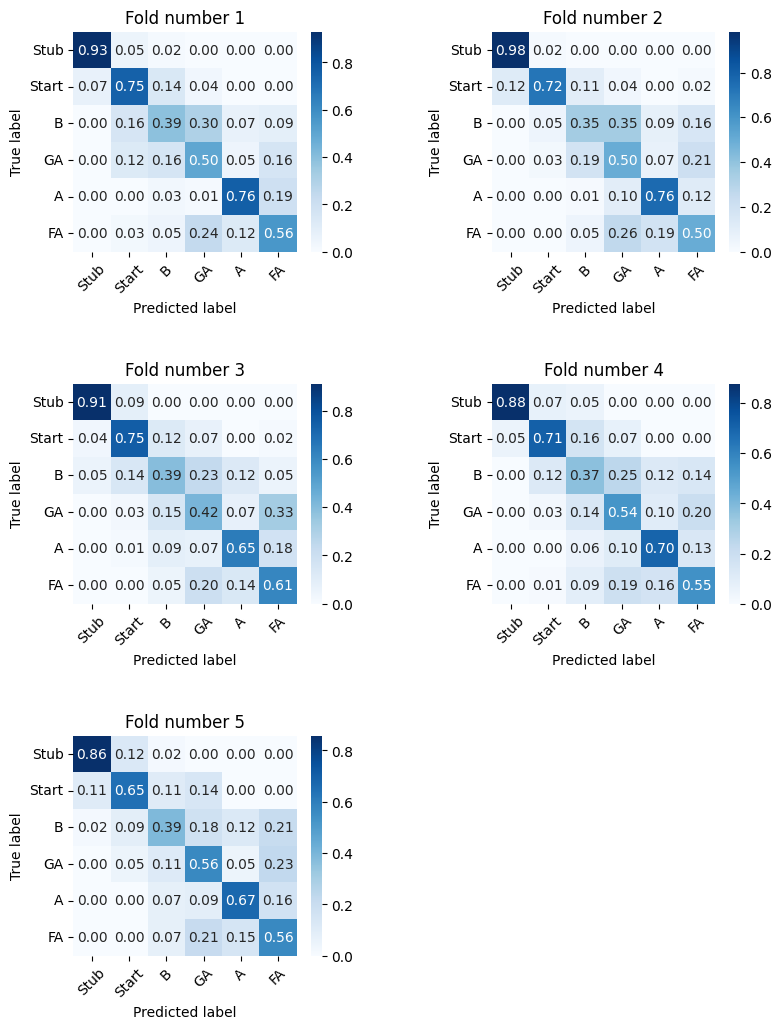

In [49]:
class_labels = ['Stub', 'Start', 'B', 'GA', 'A', 'FA']

plt.figure(figsize=(9, 12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.heatmap(cms[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(f'Fold number {i+1}')

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()

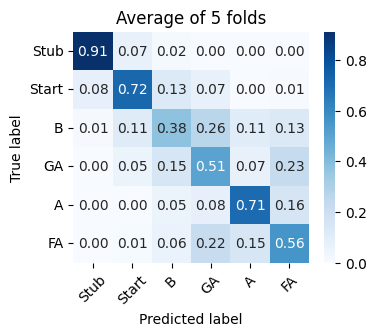

In [50]:
avg_cm = np.mean(cms, axis=0)

plt.figure(figsize=(3.8, 3))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Average of 5 folds')
plt.show()

In [51]:
for i, x in enumerate(reports):
    print(f'Fold number {i+1}:')
    print(x)
    print('\n')

Fold number 1:
              precision    recall  f1-score   support

        Stub       0.93      0.93      0.93        57
       Start       0.64      0.75      0.69        57
           B       0.44      0.39      0.41        57
          GA       0.51      0.50      0.50        80
           A       0.74      0.76      0.75        67
          FA       0.59      0.56      0.58        80

    accuracy                           0.64       398
   macro avg       0.64      0.65      0.64       398
weighted avg       0.63      0.64      0.63       398



Fold number 2:
              precision    recall  f1-score   support

        Stub       0.89      0.98      0.93        57
       Start       0.87      0.72      0.79        57
           B       0.43      0.35      0.39        57
          GA       0.44      0.50      0.47        80
           A       0.66      0.76      0.71        67
          FA       0.53      0.50      0.52        80

    accuracy                           0.62  

In [52]:
def assign_coarse_label(label):
    if label <= 1:
        return 0
    elif label <= 3:
        return 1
    else:
        return 2

df['coarse_label'] = df['label'].apply(assign_coarse_label)

In [54]:
combined_embeddings = [torch.cat((BERT, Longformer), dim=1) for BERT, Longformer in zip(df['BERT_embedding'], df['Longformer_embedding'])]
combined_embeddings = torch.stack(combined_embeddings)
combined_embeddings = combined_embeddings.squeeze(1)

labels = torch.tensor(df['coarse_label'].tolist(), dtype=torch.long)

In [56]:
class ComplexModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Assuming input tensor dimensions
input_dim = 1536
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = 3  # 3 coarse classes

model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss().to(device)

In [57]:
def train_and_evaluate_model(train_loader, test_loader, model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        if epoch % 40 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    report = classification_report(y_true, y_pred, target_names=['[\'Low\']', '[\'Medium\']', '[\'Good\']'])
    
    return cm, report


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cms = []
reports = []

num_epochs = 200

for i, (train_index, test_index) in enumerate(kf.split(combined_embeddings, labels)):
    print(f"Fold {i+1}")
    
    X_train, X_test = combined_embeddings[train_index], combined_embeddings[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    model = ComplexModel(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)
    
    cm, report = train_and_evaluate_model(train_loader, test_loader, model, criterion, optimizer, num_epochs=200)
    
    cms.append(cm)
    reports.append(report)

Fold 1
Epoch 0/200, Loss: 0.7650680047273636
Epoch 40/200, Loss: 0.0022085403744131326
Epoch 80/200, Loss: 0.00017826273804530501
Epoch 120/200, Loss: 3.598954401240917e-05
Epoch 160/200, Loss: 9.197602125823323e-06
Fold 2
Epoch 0/200, Loss: 0.7623886770009994
Epoch 40/200, Loss: 0.0014412734901998192
Epoch 80/200, Loss: 0.00016385594339226372
Epoch 120/200, Loss: 3.81543116964167e-05
Epoch 160/200, Loss: 1.0462142909091198e-05
Fold 3
Epoch 0/200, Loss: 0.7732602107524872
Epoch 40/200, Loss: 0.0015850925649283454
Epoch 80/200, Loss: 0.00015476054410100914
Epoch 120/200, Loss: 2.1250746231089577e-05
Epoch 160/200, Loss: 4.410268029459985e-06
Fold 4
Epoch 0/200, Loss: 0.7813200426101684
Epoch 40/200, Loss: 0.0012581999611575155
Epoch 80/200, Loss: 9.819469916692469e-05
Epoch 120/200, Loss: 2.093238415909582e-05
Epoch 160/200, Loss: 4.710705836714624e-06
Fold 5
Epoch 0/200, Loss: 0.763413080573082
Epoch 40/200, Loss: 0.001254798350855708
Epoch 80/200, Loss: 8.936290138080949e-05
Epoch 120

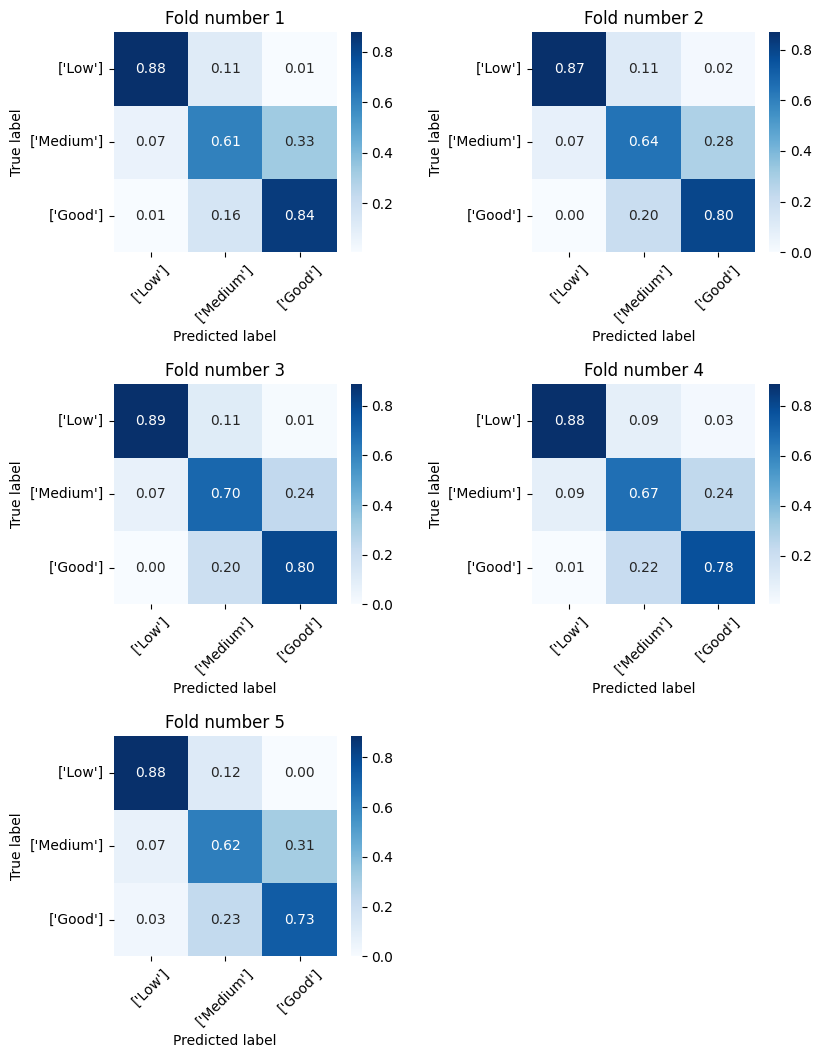

In [62]:
class_labels = ['[\'Low\']', '[\'Medium\']', '[\'Good\']']

plt.figure(figsize=(9, 12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.heatmap(cms[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(f'Fold number {i+1}')

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()

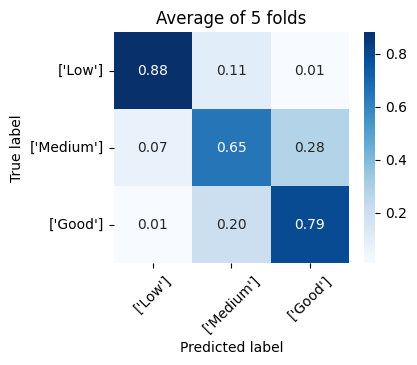

In [63]:
avg_cm = np.mean(cms, axis=0)

plt.figure(figsize=(3.8, 3))
sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title('Average of 5 folds')
plt.show()

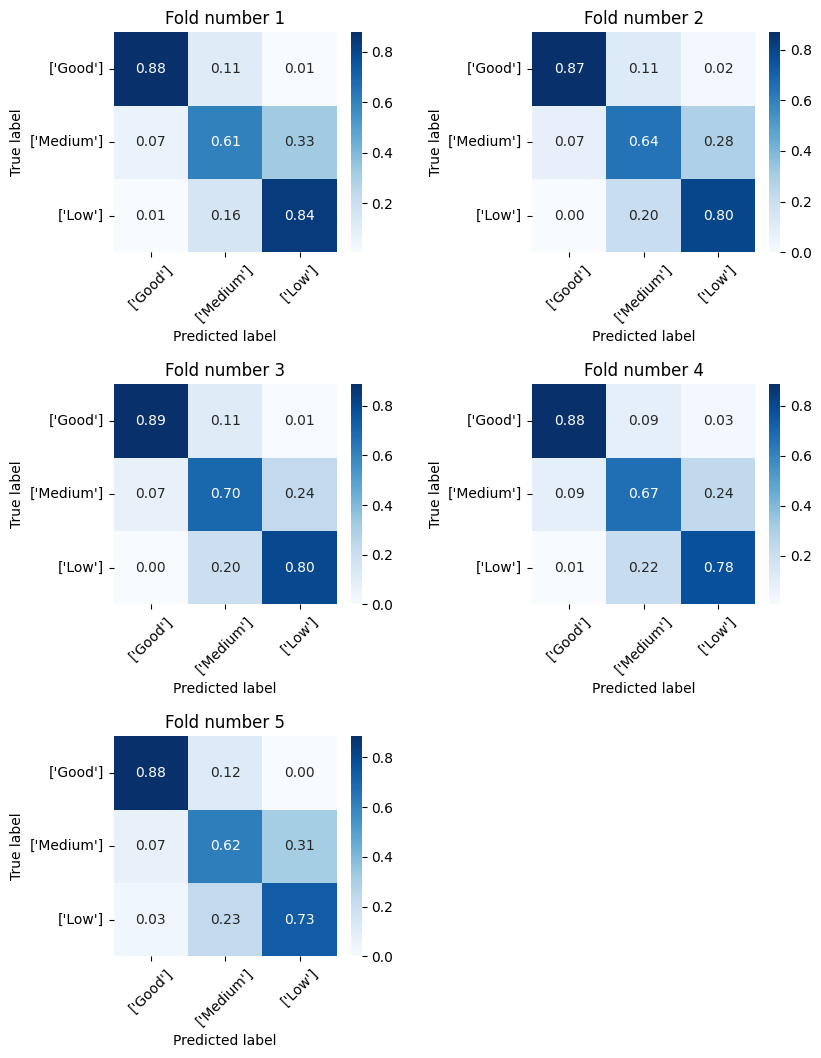

In [65]:
class_labels = ['[\'Good\']', '[\'Medium\']', '[\'Low\']']

plt.figure(figsize=(9, 12))
for i in range(5):
    plt.subplot(3, 2, i+1)
    sns.heatmap(cms[i], annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(f'Fold number {i+1}')

plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.show()

In [66]:
for i, x in enumerate(reports):
    print(f'Fold number {i+1}:')
    print(x)
    print('\n')

Fold number 1:
              precision    recall  f1-score   support

     ['Low']       0.91      0.88      0.89       114
  ['Medium']       0.70      0.61      0.65       137
    ['Good']       0.73      0.84      0.78       147

    accuracy                           0.77       398
   macro avg       0.78      0.77      0.77       398
weighted avg       0.77      0.77      0.77       398



Fold number 2:
              precision    recall  f1-score   support

     ['Low']       0.91      0.87      0.89       114
  ['Medium']       0.67      0.64      0.66       137
    ['Good']       0.74      0.80      0.77       147

    accuracy                           0.76       398
   macro avg       0.77      0.77      0.77       398
weighted avg       0.76      0.76      0.76       398



Fold number 3:
              precision    recall  f1-score   support

     ['Low']       0.92      0.89      0.90       114
  ['Medium']       0.70      0.70      0.70       136
    ['Good']       0.78   